Data Preprocessing

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PD_Class_yolov8.v2i.clip.zip to PD_Class_yolov8.v2i.clip.zip


In [2]:
import zipfile
import io

zip_file_name = 'PD_Class_yolov8.v2i.clip.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os
import cv2
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16, decode_predictions
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from matplotlib.pyplot import imread, imshow
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [4]:
pd_img_data = os.listdir(r'/content/PD_Class_yolov8.v2i.clip')
pd_img_data

['valid', 'test', 'train']

In [5]:
train_pd = r"/content/PD_Class_yolov8.v2i.clip/train"
test_pd = r"/content/PD_Class_yolov8.v2i.clip/test"
valid_df = r"/content/PD_Class_yolov8.v2i.clip/valid"

In [6]:
print(train_pd,test_pd,valid_df)

/content/PD_Class_yolov8.v2i.clip/train /content/PD_Class_yolov8.v2i.clip/test /content/PD_Class_yolov8.v2i.clip/valid


In [7]:
x_train=[]
for folder in os.listdir(train_pd):
    sub_path=train_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [8]:
x_test=[]
for folder in os.listdir(test_pd):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [9]:
x_val=[]
for folder in os.listdir(valid_df):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [10]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [11]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [13]:
training_set = train_datagen.flow_from_directory(train_pd,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_pd,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(valid_df,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1120 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [14]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [15]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((1120,), (320,), (160,))

Display Images

In [16]:
def show_img(image_generator, num_images=10):
    images, labels = image_generator.next()
    fig, axes = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

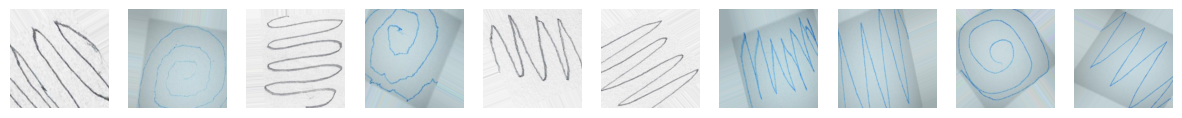

In [17]:
show_img(training_set)

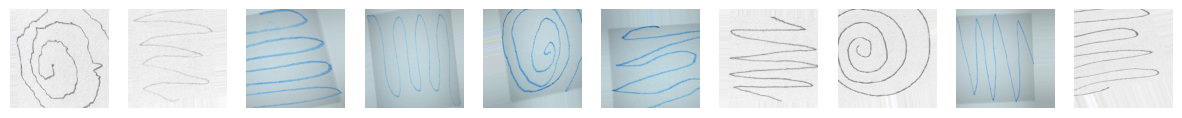

In [18]:
show_img(test_set)

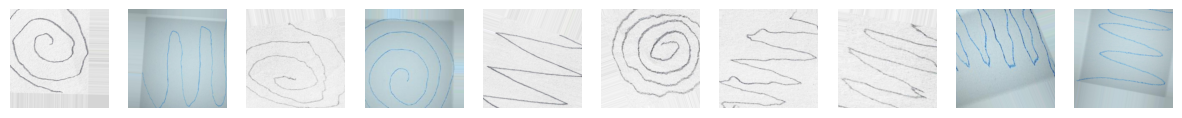

In [19]:
show_img(val_set)

Train VGG16

In [20]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [21]:
x = Flatten()(model.output)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

In [22]:
model = Model(inputs=model.input, outputs=output)

In [23]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    training_set,
    epochs=100,
    validation_data=val_set,
    callbacks=[early_stopping]
)

Epoch 1/100
35/35 [==============================] - 31s 532ms/step - loss: 12.5332 - accuracy: 0.7223 - val_loss: 11.1485 - val_accuracy: 0.6438
Epoch 2/100
35/35 [==============================] - 19s 548ms/step - loss: 10.2187 - accuracy: 0.7643 - val_loss: 9.4867 - val_accuracy: 0.6812
Epoch 3/100
35/35 [==============================] - 22s 619ms/step - loss: 8.8221 - accuracy: 0.7964 - val_loss: 8.3987 - val_accuracy: 0.7563
Epoch 4/100
35/35 [==============================] - 18s 527ms/step - loss: 7.9464 - accuracy: 0.8027 - val_loss: 7.5935 - val_accuracy: 0.8000
Epoch 5/100
35/35 [==============================] - 19s 540ms/step - loss: 7.3511 - accuracy: 0.8009 - val_loss: 6.9925 - val_accuracy: 0.8188
Epoch 6/100
35/35 [==============================] - 21s 612ms/step - loss: 6.8741 - accuracy: 0.8170 - val_loss: 6.6247 - val_accuracy: 0.8000
Epoch 7/100
35/35 [==============================] - 19s 530ms/step - loss: 6.4771 - accuracy: 0.8241 - val_loss: 6.2403 - val_accura

In [25]:
test_eval = model.evaluate(test_set)

10/10 [==============================] - 5s 522ms/step - loss: 0.9654 - accuracy: 0.8000


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {training_accuracy * 100:.2f}%")

Final Training Accuracy: 88.04%


In [30]:
print(f"Test Loss: {test_eval[0]:.4f}")
print(f"Test Accuracy: {test_eval[1]*100:.2f}%")

Test Loss: 0.9654
Test Accuracy: 80.00%


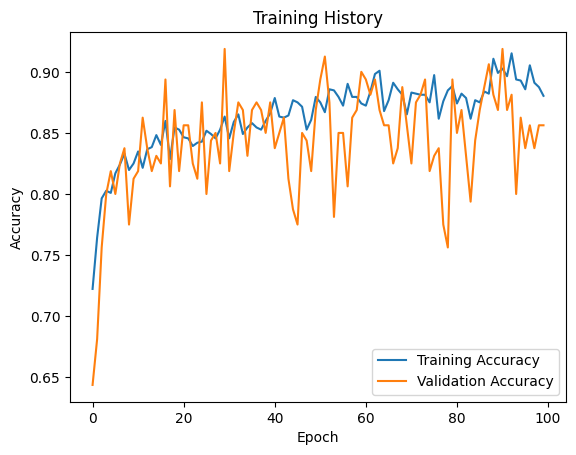

In [31]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

In [33]:
predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype(int).flatten()

10/10 [==============================] - 4s 427ms/step


In [34]:
y_true = test_set.classes

In [36]:
accuracy = accuracy_score(y_true, y_pred)

In [37]:
precision = precision_score(y_true, y_pred)

In [38]:
recall = recall_score(y_true, y_pred)

In [39]:
f1 = f1_score(y_true, y_pred)

In [40]:
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f1)

Accuracy: 0.5375
Precision: 0.5337078651685393
Recall: 0.59375
F1 Score: 0.5621301775147929


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[77 83]
 [65 95]]


In [42]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.48      0.51       160
           1       0.53      0.59      0.56       160

    accuracy                           0.54       320
   macro avg       0.54      0.54      0.54       320
weighted avg       0.54      0.54      0.54       320



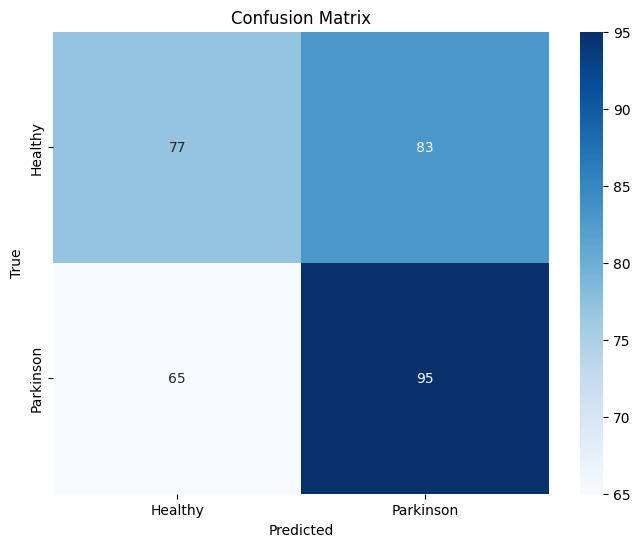

In [43]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()